<a href="https://colab.research.google.com/drive/1T2zEG8iTG4e-YOV-AQPAD41FJ3ud3qLH?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

# Image classification with modern MLP-Mixer models


Based on the paper [MLP-Mixer: An all-MLP Architecture for Vision](https://arxiv.org/abs/2105.01601) keras code [code](https://github.com/keras-team/keras-io/blob/master/examples/vision/mlp_image_classification.py)<br>

- "While convolutions and attention are both sufficient for good performance, neither of them is necessary!"
- "Mixer is a competitive but conceptually and technically simple alternative, that does not use convolutions or self-attention"
- "The idea behind the Mixer architecture is to clearly separate the per-location (channel-mixing) operations, and cross-location (token-mixing) operations. Both operations are implemented with MLPs"
- "Mixer relies only on basic matrix multiplication routines, changes to data layout (reshapes and transpositions), and scalar nonlinearities."
- "The computational complexity of the network is linear in the number of input patches, unlike ViT whose complexity is quadratic"
- "Each layer in Mixer takes an input of the same size. This “isotropic” design is most similar to Transformers"
- "Unlike ViTs, Mixer does not use position embeddings because the token-mixing MLPs are sensitive to the order of the input tokens."

The MLP-Mixer model tends to have much less number of parameters compared
to convolutional and transformer-based models, which leads to less training and
serving computational cost.



## Setup

In [ ]:
!pip install -U tensorflow-addons

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

## Prepare the data

In [ ]:
#cifar10 or cifar100
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [ ]:
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
dropout_rate = 0.2
image_size = 32 #64  # resize input images to this size.
patch_size = 8  #8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks. (4)

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 32 X 32 = 1024
Patch size: 8 X 8 = 64 
Patches per image: 16
Elements per patch (3 channels): 192


## Build a classification model

We implement a method that builds a classifier given the processing blocks.

In [ ]:
def build_classifier(blocks):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

## Define an experiment

We implement a utility function to compile, train, and evaluate a given model.

In [ ]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc")
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history


## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement patch extraction as a layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

## The MLP-Mixer model


### Implement the MLP-Mixer module

In [ ]:

class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x


### Build, train, and evaluate the MLP-Mixer model

Note that training the model with the current settings on a V100 GPUs
takes around 8 seconds per epoch.

In [ ]:
mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks)
mlpmixer_classifier.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
data_augmentation (Sequentia (None, 32, 32, 3)         7         
_________________________________________________________________
patches_9 (Patches)          (None, 16, 192)           0         
_________________________________________________________________
dense_90 (Dense)             (None, 16, 256)           49408     
_________________________________________________________________
sequential_45 (Sequential)   (None, 16, 256)           38080     
_________________________________________________________________
global_average_pooling1d_9 ( (None, 256)               0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)               0   

In [ ]:
for layer in mlpmixer_classifier.layers:
    weights = layer.get_weights()
    print("-"*30)
    print(layer.name)
    for w in weights:
      print(w.shape)

------------------------------
input_10
------------------------------
data_augmentation
(3,)
(3,)
()
------------------------------
patches_9
------------------------------
dense_90
(192, 256)
(256,)
------------------------------
sequential_45
(16, 16)
(16,)
(16, 16)
(16,)
(256, 16)
(16,)
(16, 256)
(256,)
(256,)
(256,)
(16, 16)
(16,)
(16, 16)
(16,)
(256, 16)
(16,)
(16, 256)
(256,)
(256,)
(256,)
(16, 16)
(16,)
(16, 16)
(16,)
(256, 16)
(16,)
(16, 256)
(256,)
(256,)
(256,)
(16, 16)
(16,)
(16, 16)
(16,)
(256, 16)
(16,)
(16, 256)
(256,)
(256,)
(256,)
------------------------------
global_average_pooling1d_9
------------------------------
dropout_45
------------------------------
dense_91
(256, 10)
(10,)


In [ ]:
history = run_experiment(mlpmixer_classifier)

Epoch 1/30
352/352 [==============================] - 20s 43ms/step - loss: 1.7392 - acc: 0.3674 - val_loss: 1.5035 - val_acc: 0.4556
Epoch 2/30
352/352 [==============================] - 14s 40ms/step - loss: 1.4847 - acc: 0.4624 - val_loss: 1.3697 - val_acc: 0.5054
Epoch 3/30
352/352 [==============================] - 14s 40ms/step - loss: 1.4032 - acc: 0.4957 - val_loss: 1.3201 - val_acc: 0.5238
Epoch 4/30
352/352 [==============================] - 14s 40ms/step - loss: 1.3470 - acc: 0.5121 - val_loss: 1.2548 - val_acc: 0.5478
Epoch 5/30
352/352 [==============================] - 14s 40ms/step - loss: 1.3068 - acc: 0.5329 - val_loss: 1.2712 - val_acc: 0.5430
Epoch 6/30
352/352 [==============================] - 14s 40ms/step - loss: 1.2771 - acc: 0.5431 - val_loss: 1.2354 - val_acc: 0.5612
Epoch 7/30
352/352 [==============================] - 14s 40ms/step - loss: 1.2485 - acc: 0.5513 - val_loss: 1.2609 - val_acc: 0.5440
Epoch 8/30
352/352 [==============================] - 14s 41ms

## Visualize 

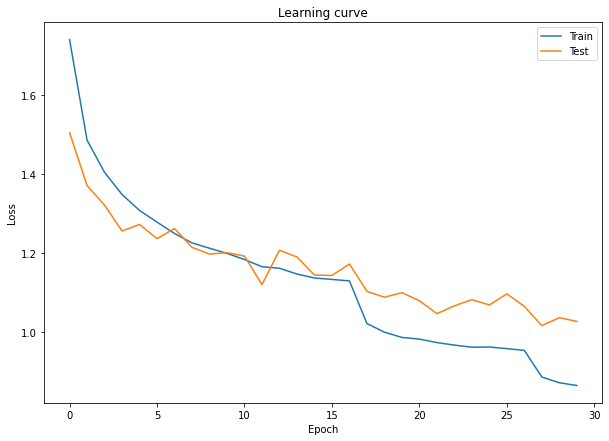

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')


plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()

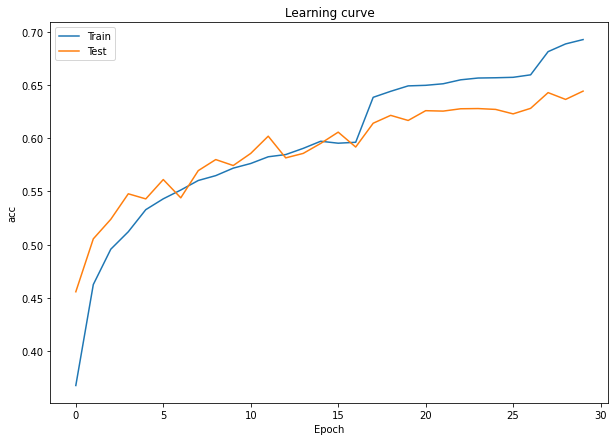

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Test')


plt.title('Learning curve')
plt.ylabel('acc')
plt.xlabel('Epoch')

plt.legend()

(16, 16)


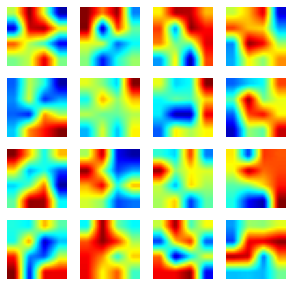

In [ ]:
# Hidden units in the token-mixing MLPs
token_mixing_mlp = mlpmixer_classifier.layers[4].get_weights()[0]
print(token_mixing_mlp.shape)
n = int(np.sqrt(token_mixing_mlp.shape[0]))
plt.figure(figsize=(5, 5))
for unit_index in range(n*n):
  ax = plt.subplot(n, n, unit_index + 1)
  feature_map  = np.reshape(token_mixing_mlp[unit_index], [n, n])
  feature_map /= np.max(feature_map)
  feature_map *= 255
  feature_map = feature_map.astype('uint8')
  feature_map = cv2.resize(feature_map, (32, 32))
  feature_map = cv2.applyColorMap(feature_map, cv2.COLORMAP_JET)
  feature_map = cv2.cvtColor(feature_map, cv2.COLOR_BGR2RGB)
  plt.imshow(feature_map)
  plt.axis("off")   


(16, 16)


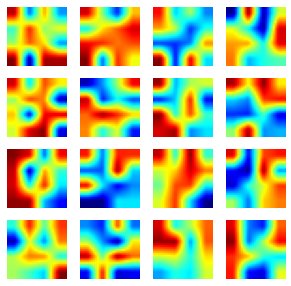

In [ ]:
token_mixing_mlp = mlpmixer_classifier.layers[4].get_weights()[10]
print(token_mixing_mlp.shape)
n = int(np.sqrt(token_mixing_mlp.shape[0]))
plt.figure(figsize=(5, 5))
for unit_index in range(n*n):
  ax = plt.subplot(n, n, unit_index + 1)
  feature_map  = np.reshape(token_mixing_mlp[unit_index], [n, n])
  feature_map /= np.max(feature_map)
  feature_map *= 255
  feature_map = feature_map.astype('uint8')
  feature_map = cv2.resize(feature_map, (32, 32))
  feature_map = cv2.applyColorMap(feature_map, cv2.COLORMAP_JET)
  feature_map = cv2.cvtColor(feature_map, cv2.COLOR_BGR2RGB)
  plt.imshow(feature_map)
  plt.axis("off")   

(16, 16)


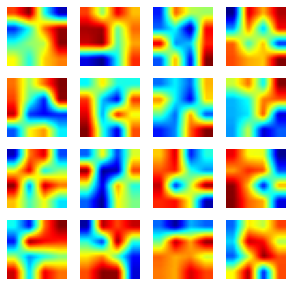

In [ ]:
token_mixing_mlp = mlpmixer_classifier.layers[4].get_weights()[20]
print(token_mixing_mlp.shape)
n = int(np.sqrt(token_mixing_mlp.shape[0]))
plt.figure(figsize=(5, 5))
for unit_index in range(n*n):
  ax = plt.subplot(n, n, unit_index + 1)
  feature_map  = np.reshape(token_mixing_mlp[unit_index], [n, n])
  feature_map /= np.max(feature_map)
  feature_map *= 255
  feature_map = feature_map.astype('uint8')
  feature_map = cv2.resize(feature_map, (32, 32))
  feature_map = cv2.applyColorMap(feature_map, cv2.COLORMAP_JET)
  feature_map = cv2.cvtColor(feature_map, cv2.COLOR_BGR2RGB)
  plt.imshow(feature_map)
  plt.axis("off")   

(16, 16)


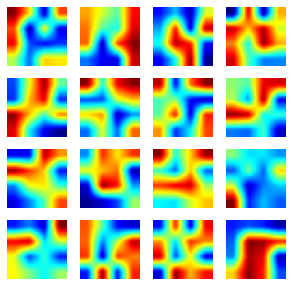

In [ ]:
token_mixing_mlp = mlpmixer_classifier.layers[4].get_weights()[30]
print(token_mixing_mlp.shape)
n = int(np.sqrt(token_mixing_mlp.shape[0]))
plt.figure(figsize=(5, 5))
for unit_index in range(n*n):
  ax = plt.subplot(n, n, unit_index + 1)
  feature_map  = np.reshape(token_mixing_mlp[unit_index], [n, n])
  feature_map /= np.max(feature_map)
  feature_map *= 255
  feature_map = feature_map.astype('uint8')
  feature_map = cv2.resize(feature_map, (32, 32))
  feature_map = cv2.applyColorMap(feature_map, cv2.COLORMAP_JET)
  feature_map = cv2.cvtColor(feature_map, cv2.COLOR_BGR2RGB)
  plt.imshow(feature_map)
  plt.axis("off")  